In [1]:
import numpy
import random
from matplotlib import pyplot
from matplotlib import colors
from matplotlib import font_manager
import matplotlib.dates as mdates
import matplotlib.ticker as mticker
import matplotlib.patches as mpatches
import matplotlib.lines as mlines
import datetime
from datetime import date
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LATITUDE_FORMATTER, LONGITUDE_FORMATTER
from PIL import Image
import pandas
from sklearn.linear_model import LinearRegression, LogisticRegression
from mpl_toolkits.mplot3d import Axes3D
import seaborn
import scipy
from scipy import stats
from scipy.stats import poisson, ttest_ind
from scipy import linalg
import xarray as xr
import os
import netCDF4
import cftime
import warnings

In [2]:
# Create List of Models
Model_List = ['MPIESM12', 'MPIESM11', 'IPSLCM5A', 'HadGEM2ES', 'HadCM3L', 'GISSE2R', 'FAMOUS', 'ECHAM5MPIOM', \
'CNRMCM61', 'CESM104', 'CCSM3']

In [3]:
# Define Directory
#Diri = "/Users/angelinependergrass/Documents/github/Long_Run_MIP_dPdT/Data/"
Diri = "data/processed/"

#
# Get Files
Precip_Files = os.listdir(Diri+"Net_CDF/")
print (Precip_Files)
Temp_Files = os.listdir(Diri+"CSV/")
print (Temp_Files)

['Precip_Anom_HadGEM2ES.nc', 'Precip_Anom_MPIESM11.nc', 'Precip_Control_MPIESM11.nc', 'Precip_Anom_GISSE2R.nc', 'Precip_Control_CESM104.nc', 'Precip_Control_GISSE2R.nc', 'Precip_Anom_CESM104.nc', 'Precip_Anom_MPIESM12.nc', 'Precip_Control_MPIESM12.nc', 'Precip_Control_ECHAM5MPIOM.nc', 'Precip_Anom_CCSM3.nc', 'Precip_Anom_CNRMCM61.nc', 'Precip_Anom_IPSLCM5A.nc', 'Precip_Anom_FAMOUS.nc', 'Precip_Control_HadGEM2ES.nc', 'Precip_Control_CNRMCM61.nc', 'Precip_Control_IPSLCM5A.nc', 'Precip_Control_CCSM3.nc', 'Precip_Control_FAMOUS.nc', 'Precip_Anom_HadCM3L.nc', 'Precip_Control_HadCM3L.nc', 'Precip_Anom_ECHAM5MPIOM.nc']
['Temp_Control.csv', 'Temp_Anom.csv']


In [4]:
def AutocorLone(x):
    a = numpy.ma.masked_invalid(x[:-1])
    b = numpy.ma.masked_invalid(x[1:])
    msk = (~a.mask & ~b.mask)
    ac = numpy.ma.corrcoef(a[msk],b[msk])[0,1]
    #print(ac)
    return ac

In [5]:
def Detrend(x):
    xc = x - x.mean()
    t = numpy.arange(len(x))
    tc = t - t.mean()
    slope, intercept, r_value, p_value, std_err = stats.linregress(tc,xc)
### Maybe I need to include the intercept here if it's nonzero? 
    xdc = xc - slope*tc
    return xdc

In [6]:
def Corr_IgnoreNaN(x,y):
    a = numpy.ma.masked_invalid(x)
    b = numpy.ma.masked_invalid(y)
    msk = (~a.mask & ~b.mask)
    c = numpy.ma.corrcoef(a[msk],b[msk])[0,1]
    #print(ac)
    return c

In [7]:
Temp_Model_List = ['MPIESM12', 'GISSE2R', 'IPSLCM5A', 'CCSM3', 'HadGEM2ES', 'CESM104', \
'ECHAM5MPIOM', 'FAMOUS', 'CNRMCM61', 'HadCM3L', 'MPIESM11']

In [8]:
%%time
# Open Temp and Precip Datasets
Temp_Anom_Filename = "Temp_Anom.csv"
Temp_Anom_DF = pandas.read_csv(Diri+"CSV/"+Temp_Anom_Filename,header=0,names=Temp_Model_List)
Temp_Cont_Filename = "Temp_Control.csv"
Temp_Cont_DF = pandas.read_csv(Diri+"CSV/"+Temp_Cont_Filename,header=0,names=Temp_Model_List)
print (Temp_Cont_DF)

      MPIESM12    GISSE2R   IPSLCM5A      CCSM3  HadGEM2ES    CESM104  \
0    287.07060  287.47086  285.07755  287.31094  286.82812  286.67440   
1    287.00793  287.47226  285.06340  287.16312  286.70032  286.60867   
2    287.03090  287.39124  285.19960  286.88880  286.70645  286.61945   
3    287.08690  287.40610  285.42860  286.69434  286.67926  286.79400   
4    286.94925  287.48453  285.24344  286.57930  286.64255  286.89764   
..         ...        ...        ...        ...        ...        ...   
995  286.93347  287.39700  285.17334  286.13086        NaN  286.46542   
996  286.85696  287.42776  285.17640  285.92440        NaN  286.59952   
997  286.85855  287.33810  285.24683  285.92383        NaN  286.54987   
998  287.01654  287.41162  285.17303  286.03192        NaN  286.51413   
999  286.92923  287.37515  285.22590  286.14145        NaN  286.50555   

     ECHAM5MPIOM     FAMOUS   CNRMCM61    HadCM3L   MPIESM11  
0      286.83594  287.66537  286.20007  287.64737  286.65024

In [9]:
# Create Precip Control Dictionary
['MPIESM12', 'MPIESM11', 'IPSLCM5A', 'HadGEM2ES', 'HadCM3L', 'GISSE2R', 'FAMOUS', 'ECHAM5MPIOM', \
'CNRMCM61', 'CESM104', 'CCSM3']

Precip_Cont_Dict = {"MPIESM12": [], "MPIESM11": [], "IPSLCM5A": [], "HadGEM2ES": [], "HadCM3L": [], "GISSE2R": [], \
"FAMOUS": [], "ECHAM5MPIOM": [], "CNRMCM61": [], "CESM104": [], "CCSM3": []}
i = 0
for Model in Model_List:
    Precip_Cont_Dict[Model] = i
    i += 1
Precip_Cont_Dict
#
# Create Precip Anomaly Dictionary
Precip_Anom_Dict = {"MPIESM12": [], "MPIESM11": [], "IPSLCM5A": [], "HadGEM2ES": [], "HadCM3L": [], "GISSE2R": [], \
"FAMOUS": [], "ECHAM5MPIOM": [], "CNRMCM61": [], "CESM104": [], "CCSM3": []}
i = 0
for Model in Model_List:
    Precip_Anom_Dict[Model] = i
    i += 1
Precip_Anom_Dict

{'MPIESM12': 0,
 'MPIESM11': 1,
 'IPSLCM5A': 2,
 'HadGEM2ES': 3,
 'HadCM3L': 4,
 'GISSE2R': 5,
 'FAMOUS': 6,
 'ECHAM5MPIOM': 7,
 'CNRMCM61': 8,
 'CESM104': 9,
 'CCSM3': 10}

In [11]:
# Create Hydrological Sensitivity Dictionary
Precip_Cont_Std_Dict = {"MPIESM12": [], "MPIESM11": [], "IPSLCM5A": [], "HadGEM2ES": [], "HadCM3L": [], "GISSE2R": [], \
"FAMOUS": [], "ECHAM5MPIOM": [], "CNRMCM61": [], "CESM104": [], "CCSM3": []}
i = 0
for Model in Model_List:
    Precip_Cont_Std_Dict[Model] = i
    i += 1
Precip_Cont_Std_Dict
#
# Create Hydrological Sensitivity Dictionary
Cont_Corr_Coef_Dict = {"MPIESM12": [], "MPIESM11": [], "IPSLCM5A": [], "HadGEM2ES": [], "HadCM3L": [], "GISSE2R": [], \
"FAMOUS": [], "ECHAM5MPIOM": [], "CNRMCM61": [], "CESM104": [], "CCSM3": []}
i = 0
for Model in Model_List:
    Cont_Corr_Coef_Dict[Model] = i
    i += 1
Cont_Corr_Coef_Dict

{'MPIESM12': 0,
 'MPIESM11': 1,
 'IPSLCM5A': 2,
 'HadGEM2ES': 3,
 'HadCM3L': 4,
 'GISSE2R': 5,
 'FAMOUS': 6,
 'ECHAM5MPIOM': 7,
 'CNRMCM61': 8,
 'CESM104': 9,
 'CCSM3': 10}

In [12]:
Precip_Cont_Dict

{'MPIESM12': <xarray.DataArray 'pr' (year: 1000, lat: 72, lon: 144)> Size: 41MB
 [10368000 values with dtype=float32]
 Coordinates:
   * lon      (lon) float64 1kB 1.25 3.75 6.25 8.75 ... 351.2 353.8 356.2 358.8
   * lat      (lat) float64 576B -88.75 -86.25 -83.75 ... 83.75 86.25 88.75
   * year     (year) int64 8kB 0 1 2 3 4 5 6 7 ... 993 994 995 996 997 998 999,
 'MPIESM11': <xarray.DataArray 'pr' (year: 1000, lat: 72, lon: 144)> Size: 41MB
 [10368000 values with dtype=float32]
 Coordinates:
   * lon      (lon) float64 1kB 1.25 3.75 6.25 8.75 ... 351.2 353.8 356.2 358.8
   * lat      (lat) float64 576B -88.75 -86.25 -83.75 ... 83.75 86.25 88.75
   * year     (year) int64 8kB 0 1 2 3 4 5 6 7 ... 993 994 995 996 997 998 999,
 'IPSLCM5A': <xarray.DataArray 'pr' (year: 1000, lat: 72, lon: 144)> Size: 41MB
 [10368000 values with dtype=float32]
 Coordinates:
   * lon      (lon) float64 1kB 1.25 3.75 6.25 8.75 ... 351.2 353.8 356.2 358.8
   * lat      (lat) float64 576B -88.75 -86.25 -83.7

In [13]:
%%time
# Open Temp Datasets
i = 0
Temp_Cont_Std = numpy.zeros(11)
for Model in Model_List:
# Open Precip Control and Temp Control Datasets
    print (Model)
    Precip_Control = Precip_Cont_Dict[Model]
    Temp_Control = Temp_Cont_DF[Model]


MPIESM12
MPIESM11
IPSLCM5A
HadGEM2ES
HadCM3L
GISSE2R
FAMOUS
ECHAM5MPIOM
CNRMCM61
CESM104
CCSM3
CPU times: user 1.91 ms, sys: 5.06 ms, total: 6.96 ms
Wall time: 9.68 ms


In [17]:
%%time
# Open Temp Datasets
i = 0
Temp_Cont_Std = numpy.zeros(11)
for Model in Model_List:
# Open Precip Control and Temp Control Datasets
    print (Model)
    Temp_Control = Temp_Cont_DF[Model]
#
# Calculate Standard Deviation of Temp Control
    Temp_Cont_Std[i] = numpy.std(Temp_Control)
#
# Append Into Dictionary
    i += 1

MPIESM12
MPIESM11
IPSLCM5A
HadGEM2ES
HadCM3L
GISSE2R
FAMOUS
ECHAM5MPIOM
CNRMCM61
CESM104
CCSM3
CPU times: user 4.15 ms, sys: 6.2 ms, total: 10.4 ms
Wall time: 11.8 ms


In [18]:
Temp_Cont_Std

array([0.1206931 , 0.12326867, 0.10947095, 0.13059746, 0.17845314,
       0.06952868, 0.1823308 , 0.21029487, 0.15160511, 0.14768871,
       0.11791135])

In [14]:
# Create Hydrological Sensitivity Dictionary
Hydro_Sensi_Dict = {"MPIESM12": [], "MPIESM11": [], "IPSLCM5A": [], "HadGEM2ES": [], "HadCM3L": [], "GISSE2R": [], \
"FAMOUS": [], "ECHAM5MPIOM": [], "CNRMCM61": [], "CESM104": [], "CCSM3": []}
i = 0
for Model in Model_List:
    Hydro_Sensi_Dict[Model] = i
    i += 1
Hydro_Sensi_Dict

{'MPIESM12': 0,
 'MPIESM11': 1,
 'IPSLCM5A': 2,
 'HadGEM2ES': 3,
 'HadCM3L': 4,
 'GISSE2R': 5,
 'FAMOUS': 6,
 'ECHAM5MPIOM': 7,
 'CNRMCM61': 8,
 'CESM104': 9,
 'CCSM3': 10}

In [15]:
def CalcParams_Fixed_iv(xdat,sxi,ydat,syi,pit):
    """
    Calculate the parameters, both intercepts as well as the slope of the regression
    :return:
    """
    # backwards compatibility with calcparams

    [sxi,syi,pit]=Backwards_Compat(sxi,syi,pit)

        
    xbar = xdat.mean()
    ybar = ydat.mean()

    xp = xdat-xbar
    yp = ydat-ybar

    sum_xp2 = numpy.sum(xp*xp)
    sum_yp2 = numpy.sum(yp*yp)
    sum_xpyp = numpy.sum(xp*yp)

    c1 = pit*sxi*syi*sum_xp2 - numpy.power(sxi,2)*sum_xpyp
    c2 = - numpy.power(syi,2)*sum_xp2 + numpy.power(sxi,2)*sum_yp2
    c3 = numpy.power(syi,2)*sum_xpyp - pit*sxi*syi*sum_yp2
    
    ## negative root
    bcalc = (-c2 - numpy.sqrt(numpy.power(c2,2)-4*c1*c3)) / 2 / c1 
    #balt = (-c2 + numpy.sqrt(numpy.power(c2,2)-4*c1*c3)) / 2 / c1 ### positive root appears to be unumpyhysical

    # now that slope is determined, calculate the y intercept
    yinter = ybar - bcalc * xbar

    # now done, so write back slope
    slope = bcalc

    # calculate x intercept
    xinter = -yinter / slope

    return numpy.array(slope), numpy.array(yinter), numpy.array(xinter), xbar, ybar

def CalcUnc_Fixed_iv(xdat,sxi,ydat,syi,xbar,ybar,b,pit):
    """
    Calculates the uncertainty of the slope and y
    """
    # backwards compatibility with calcunc
    [sxi,syi,pit]=Backwards_Compat(sxi,syi,pit)

        
    # let us first calculate the derivatives
    # dell theta / dell b (dthdb) calculation
    wi = Calc_Wi(sxi, syi, b, pit)
    sxyi = pit * sxi * syi

    ui = xdat - xbar
    vi = ydat - ybar
    
    sum1 = numpy.sum( wi**2. * (2 * b * (ui * vi * sxi**2. - ui**2. * sxyi) + (ui**2. * syi**2. - vi**2 * sxi**2.)) )
    sum2 = numpy.sum( wi**3. * (sxyi - b * sxi**2.) * (b**2. * (ui * vi * sxi**2 - ui**2 * sxyi) +
                                             b * (ui**2 * syi**2 - vi**2 * sxi**2) -
                                             (ui * vi * syi**2 - vi**2 * sxyi)) )
    
    # sum1 = 0.
    # sum2 = 0.
    # for it in range(len(xdat)):
    #     xi = xdat[it]
    #     yi = ydat[it]
    #     # sxi = xunc[it]
    #     # syi = yunc[it]
    #     # pit = p[it]
    #     # wi = calc_wi(xunc[it], yunc[it], b, pit)
    #     ui = xi - xbar
    #     vi = yi - ybar
    #     sum1 += wi**2. * (2 * b * (ui * vi * sxi**2. - ui**2. * sxyi) + (ui**2. * syi**2. - vi**2 * sxi**2.))
    #     sum2 += wi**3. * (sxyi - b * sxi**2.) * (b**2. * (ui * vi * sxi**2 - ui**2 * sxyi) +
    #                                              b * (ui**2 * syi**2 - vi**2 * sxi**2) -
    #                                              (ui * vi * syi**2 - vi**2 * sxyi))

    dthdb = sum1 + 4. * sum2

    # calculate the sum of all weights
    wksum = wi * len(xdat)

    sxj = sxi
    syj = syi
    pjt = pit
    wj = wi 
    sxyj = sxyi
    uj = xdat - xbar
    vj = ydat - ybar
            
    # now calculate sigasq and sigbsq
    sigasq = 0.
    sigbsq = 0.
    for it in range(len(xdat)):
        # calculate dell theta / dell xi and dell theta / dell yi

        kron_arr = numpy.array([kron(it,jt) for jt in range(len(xdat))])
        dthdxi = numpy.sum( wj**2. * (kron_arr - wi / wksum) * (b**2 * (vj * sxj**2 - 2 * uj * sxyj) +
                                                          2 * b * uj * syj**2 - vj * syj**2) ) 
        # correct equation! not equal to equation 21 in Mahon (1996)
        dthdyi = numpy.sum( wj**2. * (kron_arr - wi / wksum) * (b**2 * uj * sxj**2 + 2 * vj * sxyj -
                                                            2 * b * vj * sxj**2. - uj * syj**2) ) 
        # dthdxi = 0.
        # dthdyi = 0.
        # for jt in range(len(xdat)):
        #     # add to dthdxi and dthdyi
        #     dthdxi += wj**2. * (kron(it, jt) - wi / wksum) * (b**2 * (vj * sxj**2 - 2 * uj * sxyj) +
        #                                                       2 * b * uj * syj**2 - vj * syj**2)
        #     # correct equation! not equal to equation 21 in Mahon (1996)
        #     dthdyi += wj ** 2. * (kron(it, jt) - wi / wksum) * (b ** 2 * uj * sxj ** 2 + 2 * vj * sxyj -
        #                                                        2 * b * vj * sxj**2. - uj * syj ** 2)

        # now calculate dell a / dell xi and dell a / dell yi
        dadxi = -b * wi / wksum - xbar * dthdxi / dthdb
        dadyi = wi / wksum - xbar * dthdyi / dthdb

        # now finally add to sigasq and sigbsq
        sigbsq += dthdxi**2. * sxi**2. + dthdyi**2. * syi**2. + 2 * sxyi * dthdxi * dthdyi
        sigasq += dadxi**2. * sxi**2. + dadyi**2. * syi**2. + 2 * sxyi * dadxi * dadyi

    # now divide sigbsq
    sigbsq /= dthdb**2.

    yinterunc = numpy.sqrt(sigasq)
    slopeunc = numpy.sqrt(sigbsq)

    return numpy.array(slopeunc), numpy.array(yinterunc) 

def Backwards_Compat(sxi,syi,pit):
    try:
        if len(pit)>1: pit=pit[0]
    except:
        pass

    try:
        if len(syi)>1: syi=syi[0]
    except:
        pass
    
    try:
        if len(sxi)>1: sxi=sxi[0]
    except:
        pass
    return sxi,syi,pit

def CalcMswd_Fixed_iv(xdat, sxi, ydat, syi, pit, slope, yinter ):
    [sxi,syi,pit]=backwards_compat(sxi,syi,pit)
        
    wi = Calc_Wi(sxi, syi, slope, pit)
    mswd = numpy.sum( wi * ((ydat - slope*xdat - yinter)**2.)) / (len(xdat) - 2.)
    # now divide by degrees of freedom minus 2, since 2 fixed parameters
    return mswd

def Calc_Wi(sx, sy, b, p):
    return 1. / (sy**2 + b**2 * sx**2 - 2 * b * p * sx * sy)


def kron(i, j):
    # calculates Kronecker delta
    if i == j:
        return 1.
    else:
        return 0.


# example of implementation
#slope1, yinter1, xinter1, xbar1, ybar1 = calcparams_fixed_iv(xdat,xunc,ydat,yunc,p)
#slope1unc, yinter1unc = calcunc_fixed_iv(xdat,xunc,ydat,yunc,xbar1,ybar1,slope1,p)

In [16]:
# Calculate Regression Line using York regression
def New_York_Reg(x,y,Corr,Std_x,Std_y):
    N = len(x)
# Just in case they didn't agree (e.g., MPIESM11)
    x = numpy.array(x)
    y = numpy.array(y)
    Slope, Intercept, xinter1, xbar1, ybar1 = CalcParams_Fixed_iv(x,Std_x,y,Std_y,Corr)
#
## Calculate Predictions
    Predictions = x * Slope + Intercept

    Slope1unc, yInter1unc = CalcUnc_Fixed_iv(x,numpy.array(Std_x),y,numpy.array(Std_y),xbar1,ybar1,Slope,numpy.array(Corr))

# TO DO LATER: 
## Calculate Error Bars
## t-statistic for N-2 dof at 84% confidence: appropriate for comparing overlap 
    Z84 = stats.t.ppf(0.84, N-2)
    Error_Bar = Slope1unc * Z84
#
## Return Output
    return [Slope, Intercept, Error_Bar, Predictions]

## time- and memory-intensive calculations begin here

In [64]:
i=0
for Model in Model_List:
    Precip_Control_Filename = "Precip_Control_"+Model+".nc"
    Precip_Control_Data = xr.open_dataset(Diri+"Net_CDF/"+Precip_Control_Filename, use_cftime=True).pr
    #
    if Model == "CESM104":
        Precip_Control_Data = Precip_Control_Data * 1000
        
    Precip_Anom_Filename = "Precip_Anom_"+Model+".nc"
    Precip_Anom_Data = xr.open_dataset(Diri+"Net_CDF/"+Precip_Anom_Filename, use_cftime=True).pr
    #
    if Model == "CESM104":
        Precip_Anom_Data = Precip_Anom_Data * 1000
    
    print (Model)
    Precip_Control = Precip_Control_Data #Precip_Cont_Dict[Model]
    Temp_Control = Temp_Cont_DF[Model]
    Precip_Cont_Length = len(Precip_Control[:,0,0])
    
    #
    # Create Array of Longitude and Latitudes
    Longitude = numpy.array(Precip_Control.lon)
    Latitude = numpy.array(Precip_Control.lat)
    Time_Period = ["1-20 Years", "21-150 Years", "151-1000 Years"]
    
    # Create Empty 3D Array to Store Hydrological Sensitivities
    Slopes_Array = numpy.zeros((len(Latitude),len(Longitude),3))
    
    Precip_Anom = Precip_Anom_Data
    Temp_Anom = Temp_Anom_DF[Model]
    Temp_Control_Std = Temp_Cont_Std[i]
    #Precip_Control_Std = Precip_Cont_Std_Dict[Model]
    #Control_Corr = Cont_Corr_Coef_Dict[Model]
    
    # we will only loop over space once per model.
    for j in range(len(Latitude)):
        print (j)
        for k in range(len(Longitude)):
            # Calculate Standard Deviation of Precip Control
            Precip_Cont_Std = numpy.std(Precip_Control[:,j,k])
            Corr_Coef = Corr_IgnoreNaN(Temp_Control[:Precip_Cont_Length],Precip_Control[:,j,k])

            # Calculate Hydrological Sensitivity for 1-20 Years, 21-150 Years, 151-1000 Years
            Precip_1_20_Slope = New_York_Reg(Temp_Anom[0:20], Precip_Anom[0:20,j,k], \
            Corr_Coef, Temp_Control_Std, Precip_Cont_Std)[0]
            Precip_21_150_Slope = New_York_Reg(Temp_Anom[20:150], Precip_Anom[20:150,j,k], \
            Corr_Coef, Temp_Control_Std, Precip_Cont_Std)[0]
            if Model != "HadGEM2ES":
                Precip_151_1000_Slope = New_York_Reg(Temp_Anom[150:1000], Precip_Anom[150:1000,j,k], \
                Corr_Coef, Temp_Control_Std, Precip_Cont_Std)[0]
            # Ignore Years with No Data For HadGEM2ES
            else:
                if j == 0 and k == 0:
                    Temp_Anom_No_NaN = []
                    for l in range(850):
                        if l+150 in Precip_Anom.year:
                            Temp_Anom_No_NaN.append(Temp_Anom[l+150])
                    Temp_Anom_New = numpy.array(Temp_Anom_No_NaN)
                Precip_151_1000_Slope = New_York_Reg(Temp_Anom_New, Precip_Anom[150:1000,j,k], \
                Corr_Coef, Temp_Control_Std, Precip_Cont_Std)[0]        
            # Input Data into Slopes Array
            Slopes_Array[j][k][0] = Precip_1_20_Slope
            Slopes_Array[j][k][1] = Precip_21_150_Slope
            Slopes_Array[j][k][2] = Precip_151_1000_Slope
            
    # Create DataArray to Store Hydrological Sensitivities
    Slopes_DA = xr.DataArray(data=Slopes_Array, dims=["Latitude", "Longitude", "Time Period"],
    coords=dict(Lat=("Latitude", Latitude), Lon=("Longitude", Longitude), \
    Period=("Time Period", Time_Period)))
    # write it out to netcdf so we dont have to do this again
    Filename_1 = Diri+"HSdict/"+"Hydro_Sensi_"+Model+".nc"
    Slopes_DA.to_netcdf(path=Filename_1)
    #
    # Append Into Dictionary
    Hydro_Sensi_Dict[Model] = Slopes_DA
    # clean up 
    Precip_Control_Data.close()
    Precip_Anom_Data.close()
    del Precip_Anom,Precip_Anom_Data,Precip_Control_Data,Precip_Control
    i += 1

IPSLCM5A
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
HadGEM2ES
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
HadCM3L
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
GISSE2R
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
FAMOUS
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47


In [27]:
# Create Function to Plot Maps
def Map_Plotting(Model, Period):
# Create Figure
    Fig = pyplot.figure(figsize=(15, 8))
#
# Define Axis
    Axis = Fig.add_subplot(1, 1, 1, projection=ccrs.Robinson(central_longitude=180))
#
# Define Colour Levels
    Colour_Levels = numpy.empty(21)
    for i in range(len(Colour_Levels)):
        Colour_Levels[i] = 5 * i - 50
#
# Plot Colour Contour For 1-20 Years Slope
    if Period == "1-20 Years":
        Period_Code = 0
    if Period == "21-150 Years":
        Period_Code = 1
    if Period == "151-1000 Years":
        Period_Code = 2
    Hydro_Sensi_Data = Hydro_Sensi_Dict[Model][:,:,Period_Code]
    Colour_Plot = Axis.contourf(Hydro_Sensi_Data.Lon, Hydro_Sensi_Data.Lat, Hydro_Sensi_Data, \
    cmap='BrBG', levels=Colour_Levels, extend="both", transform=ccrs.PlateCarree())
#
# Draw Coastlines
    Axis.coastlines()
#
# Set Axes Labels
    x_Axis = []
    for l in range(13):
        x_Axis.append(30*l-180)
    y_Axis = []
    for k in range(13):
        y_Axis.append(15*k-90)
#    Axis.set_xticks(x_Axis)
#    Axis.set_yticks(y_Axis)
#
# Add a Rectangular Line Grid to the Interior of the Plot
    Gridline = Axis.gridlines(crs=ccrs.PlateCarree(), linewidth=0.3, color='black', linestyle='--')
    Gridline.xlocator = mticker.FixedLocator(x_Axis)
    Gridline.ylocator = mticker.FixedLocator(y_Axis)
#
# Create Colour Bar
    Colour_Bar = pyplot.colorbar(Colour_Plot, shrink=0.6)
#
# Add Title
    Title = Period + " Hydrological Sensitivity by " + Model + " (New York Method)"
    pyplot.title(Title, fontsize=18)

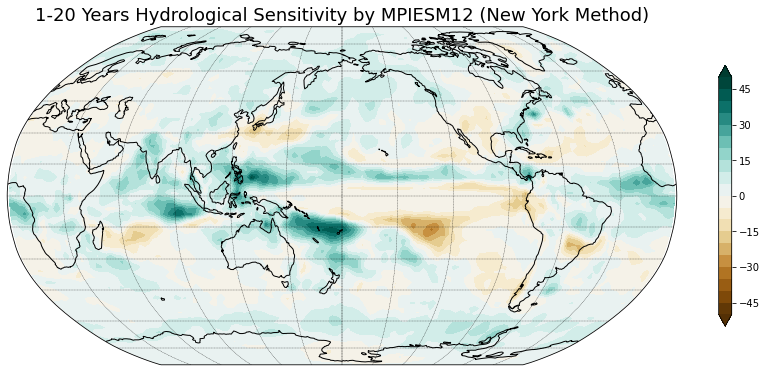

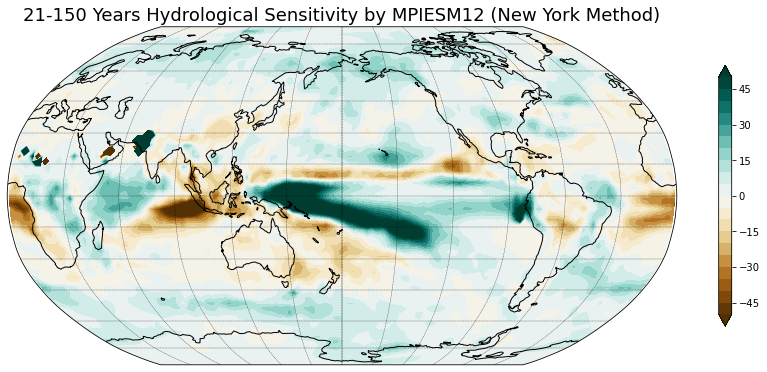

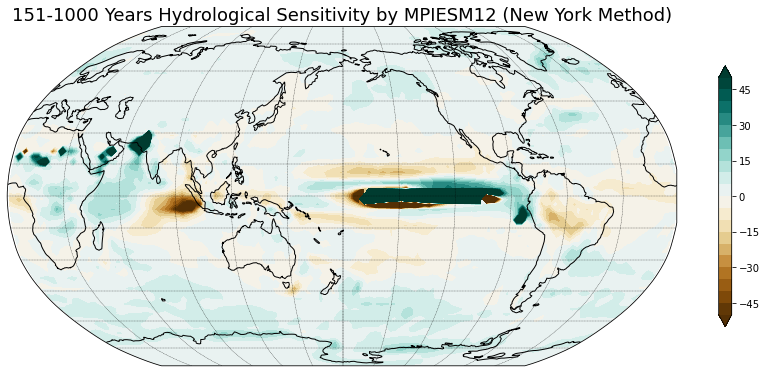

In [124]:
# Plot Contour Map
Map_Plotting("MPIESM12", "1-20 Years")
Map_Plotting("MPIESM12", "21-150 Years")
Map_Plotting("MPIESM12", "151-1000 Years")

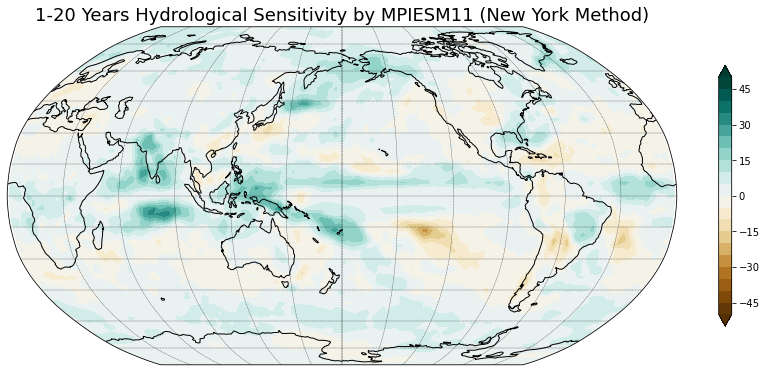

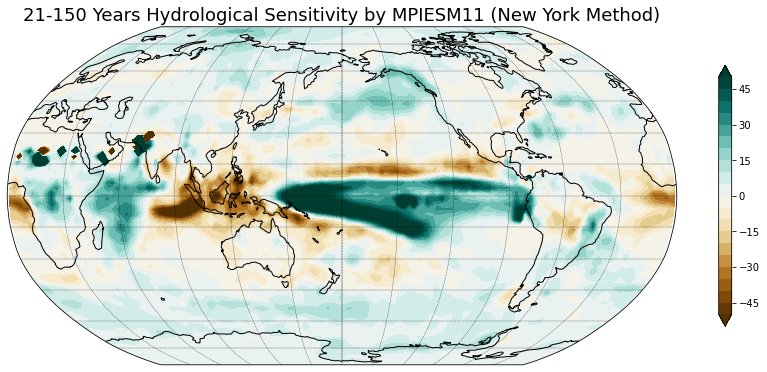

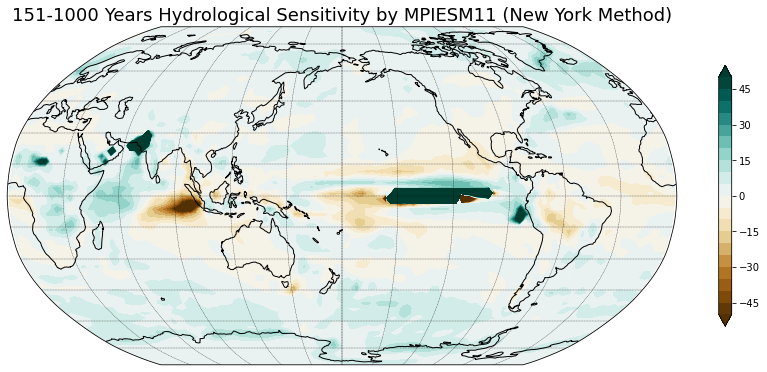

In [125]:
# Plot Contour Map
Map_Plotting("MPIESM11", "1-20 Years")
Map_Plotting("MPIESM11", "21-150 Years")
Map_Plotting("MPIESM11", "151-1000 Years")

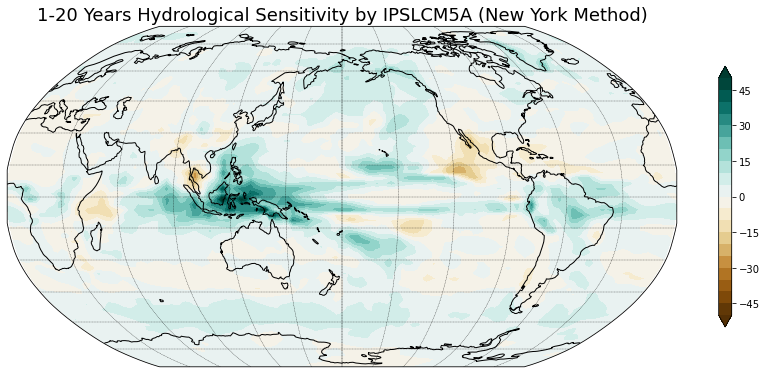

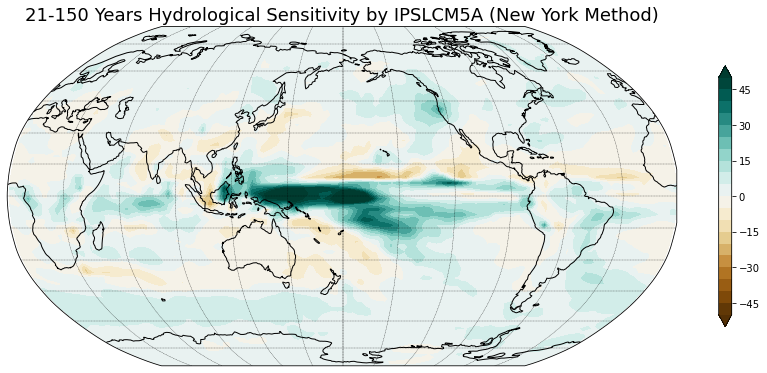

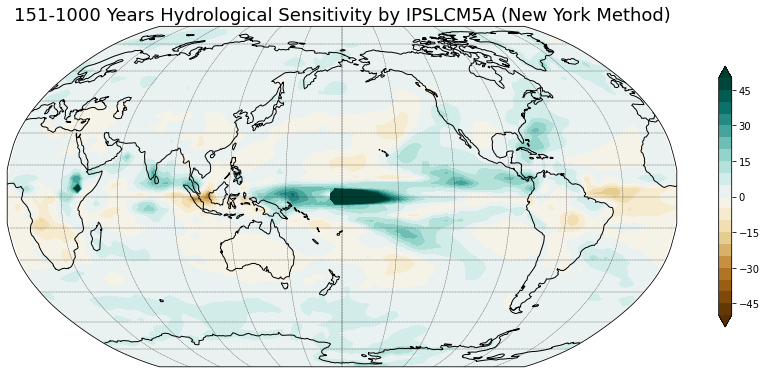

In [126]:
# Plot Contour Map
Map_Plotting("IPSLCM5A", "1-20 Years")
Map_Plotting("IPSLCM5A", "21-150 Years")
Map_Plotting("IPSLCM5A", "151-1000 Years")

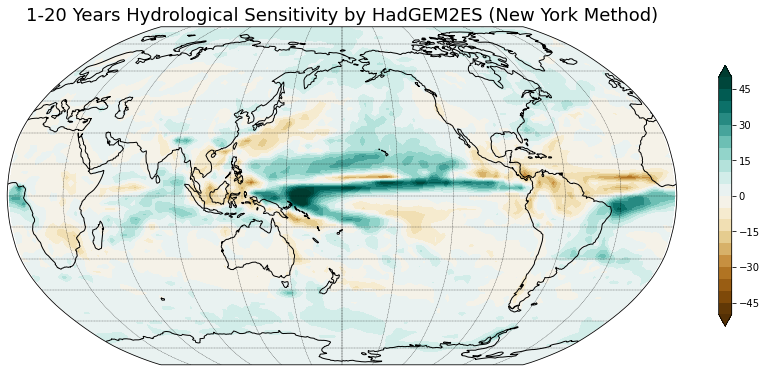

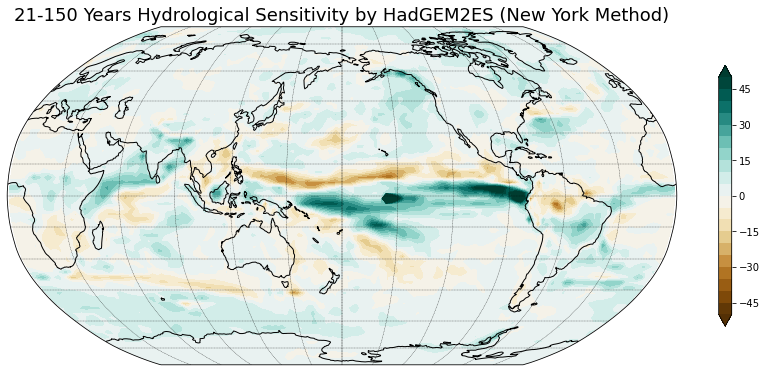

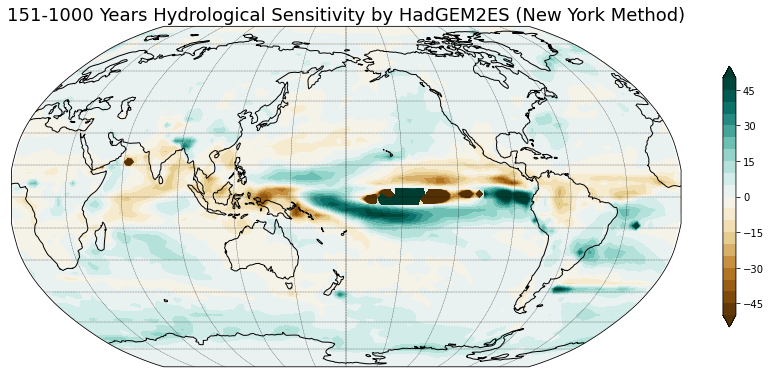

In [127]:
# Plot Contour Map
Map_Plotting("HadGEM2ES", "1-20 Years")
Map_Plotting("HadGEM2ES", "21-150 Years")
Map_Plotting("HadGEM2ES", "151-1000 Years")

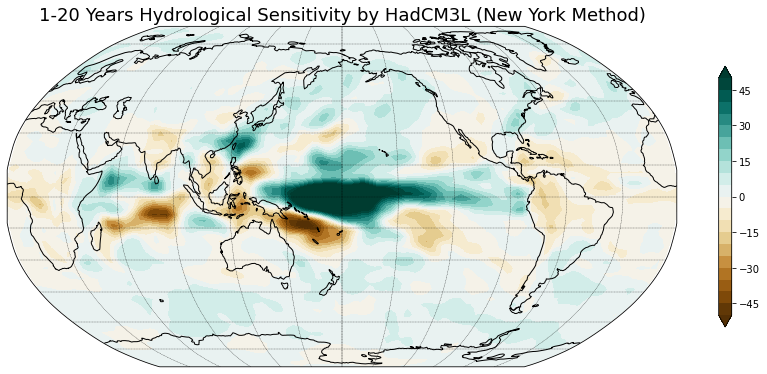

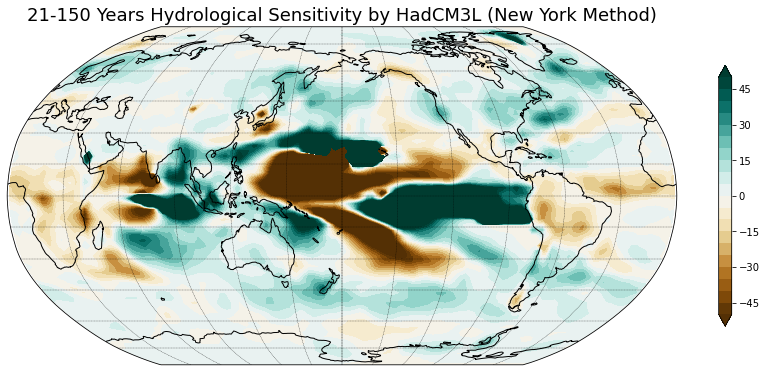

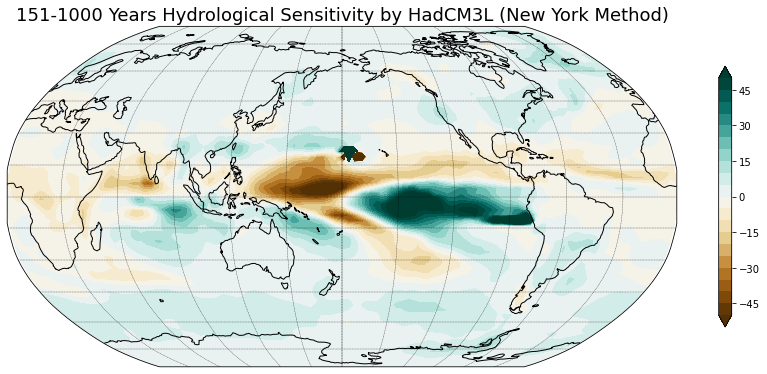

In [128]:
# Plot Contour Map
Map_Plotting("HadCM3L", "1-20 Years")
Map_Plotting("HadCM3L", "21-150 Years")
Map_Plotting("HadCM3L", "151-1000 Years")

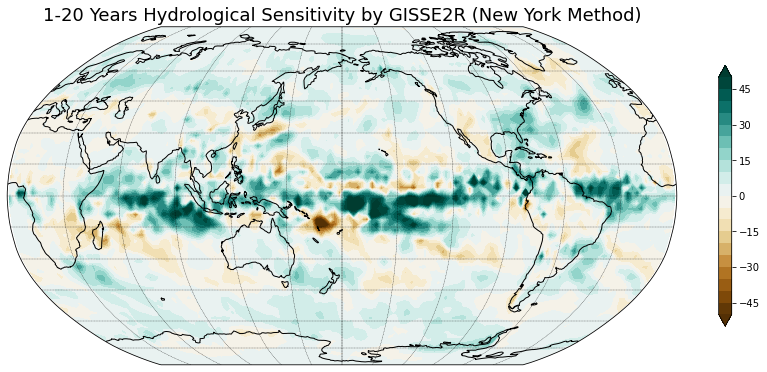

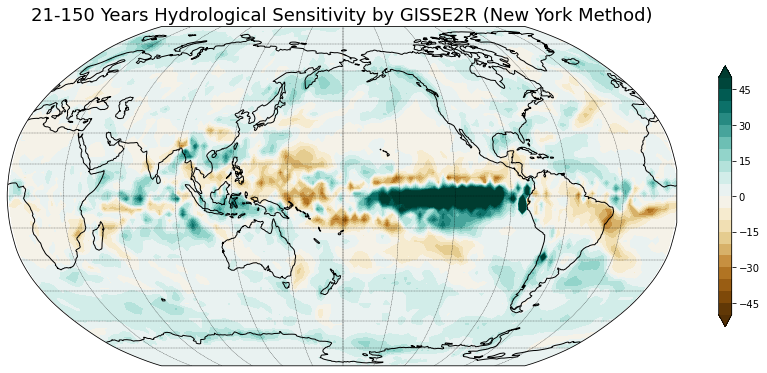

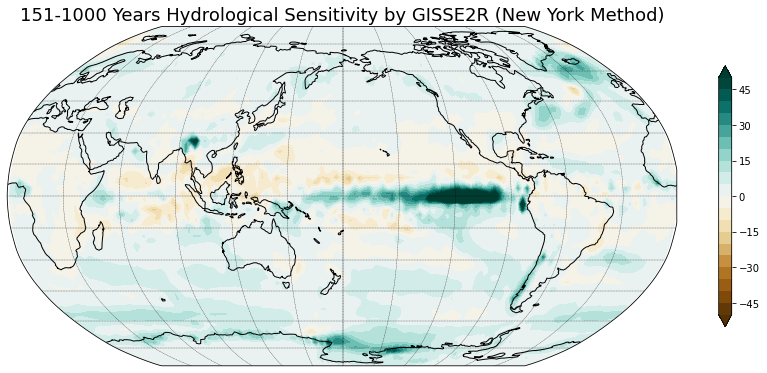

In [129]:
# Plot Contour Map
Map_Plotting("GISSE2R", "1-20 Years")
Map_Plotting("GISSE2R", "21-150 Years")
Map_Plotting("GISSE2R", "151-1000 Years")

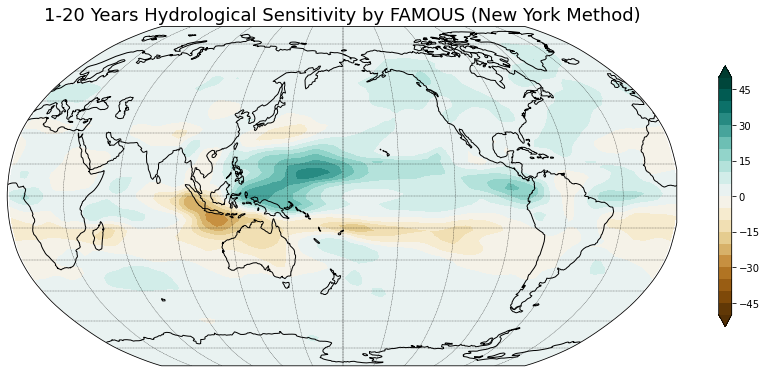

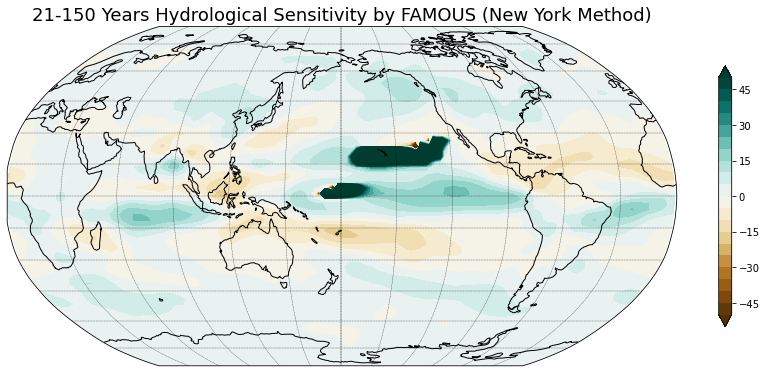

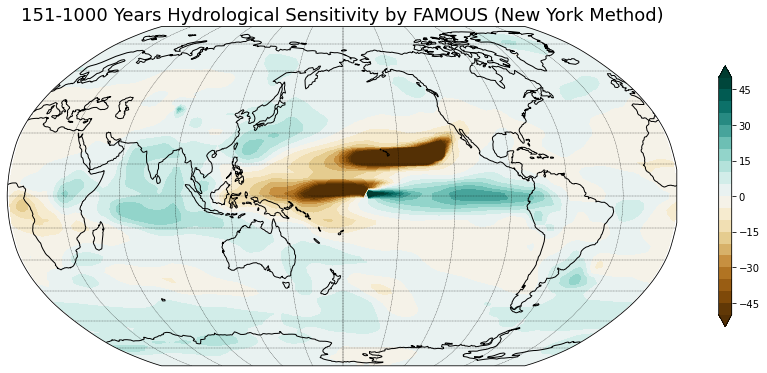

In [130]:
# Plot Contour Map
Map_Plotting("FAMOUS", "1-20 Years")
Map_Plotting("FAMOUS", "21-150 Years")
Map_Plotting("FAMOUS", "151-1000 Years")

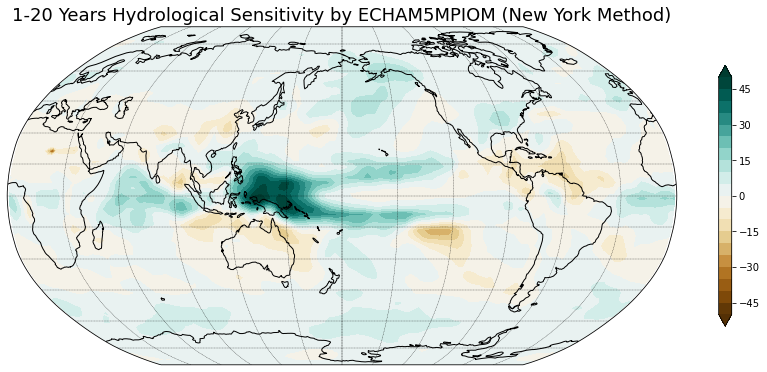

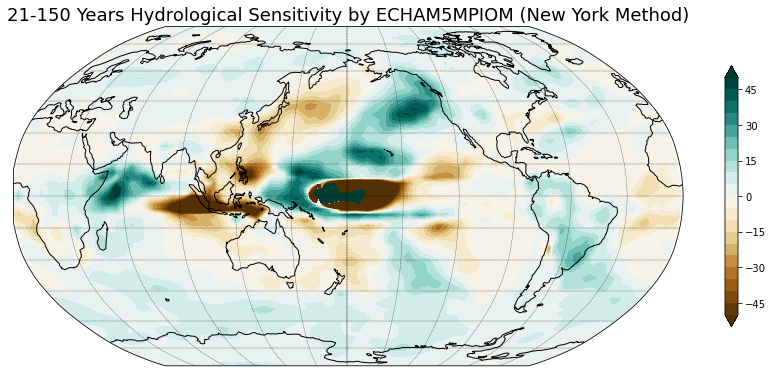

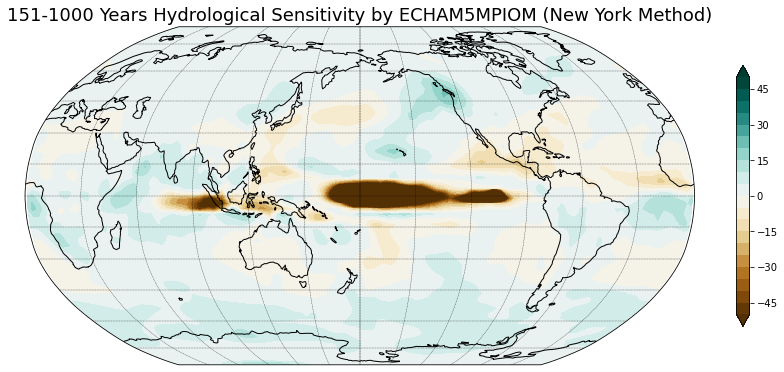

In [131]:
# Plot Contour Map
Map_Plotting("ECHAM5MPIOM", "1-20 Years")
Map_Plotting("ECHAM5MPIOM", "21-150 Years")
Map_Plotting("ECHAM5MPIOM", "151-1000 Years")

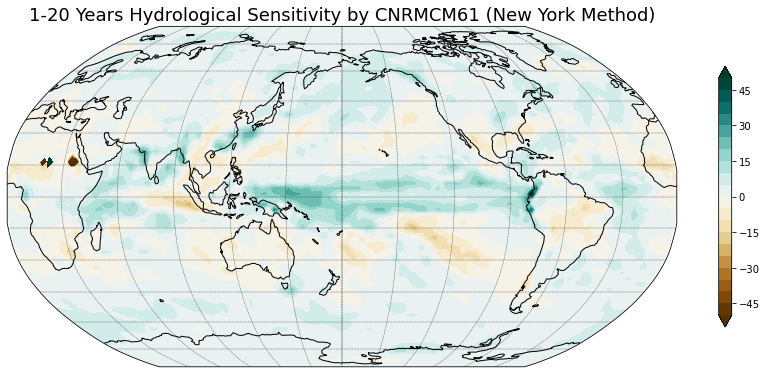

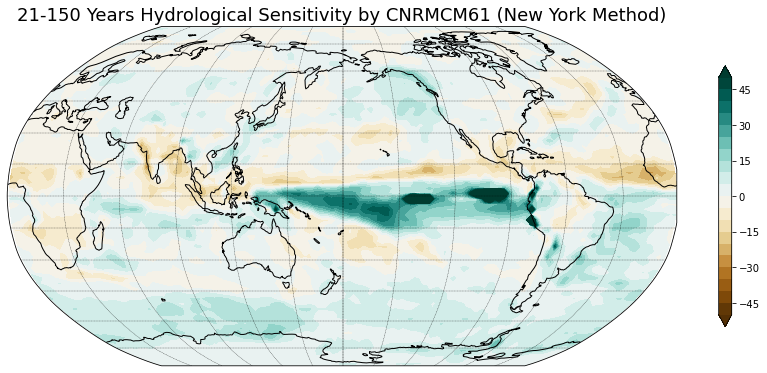

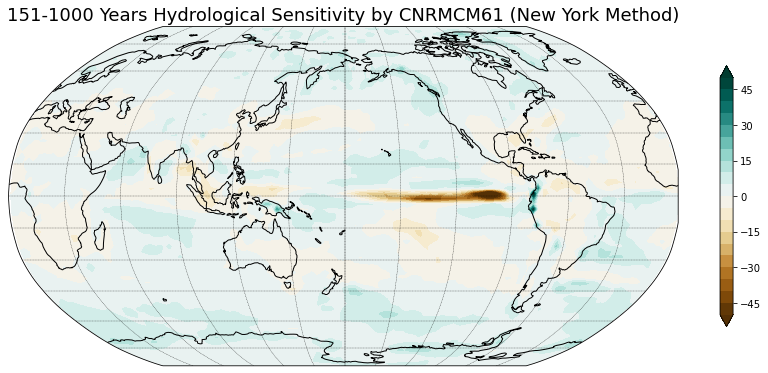

In [132]:
# Plot Contour Map
Map_Plotting("CNRMCM61", "1-20 Years")
Map_Plotting("CNRMCM61", "21-150 Years")
Map_Plotting("CNRMCM61", "151-1000 Years")

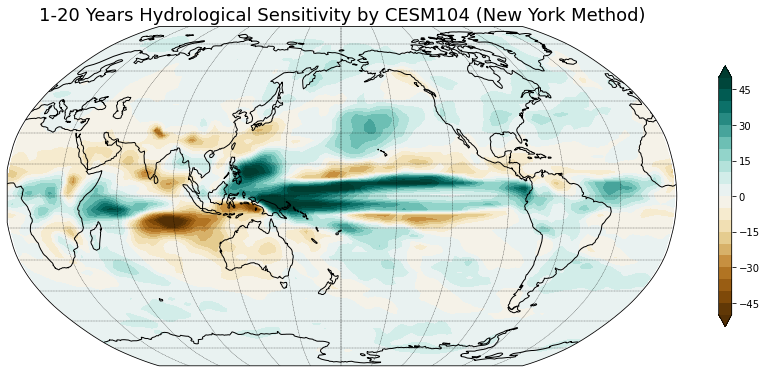

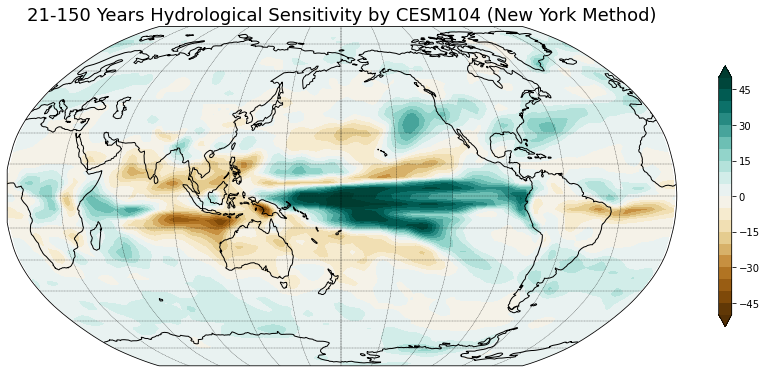

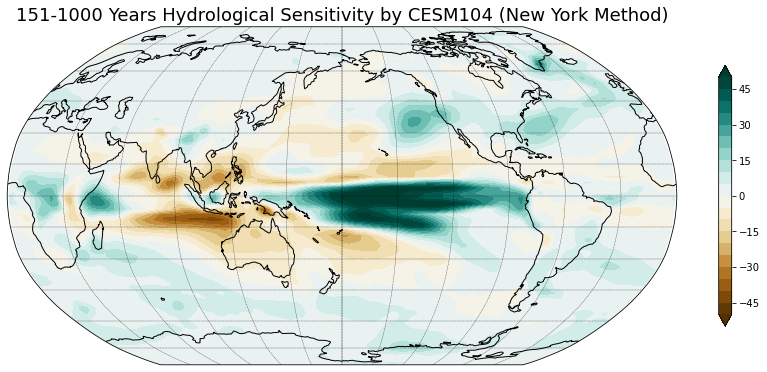

In [133]:
# Plot Contour Map
Map_Plotting("CESM104", "1-20 Years")
Map_Plotting("CESM104", "21-150 Years")
Map_Plotting("CESM104", "151-1000 Years")

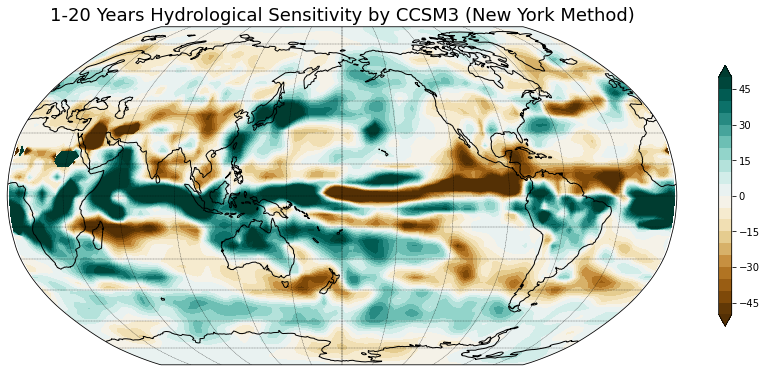

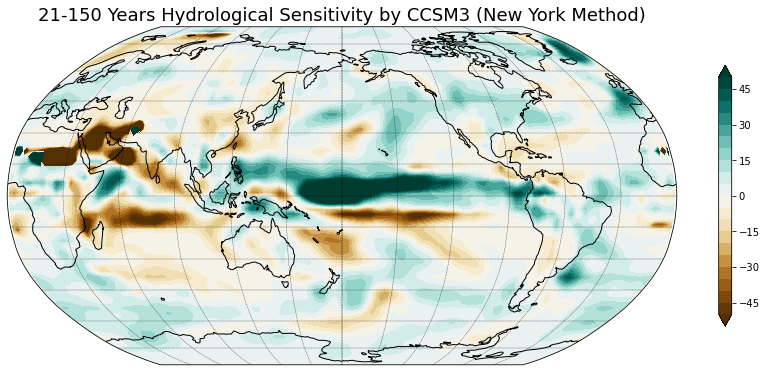

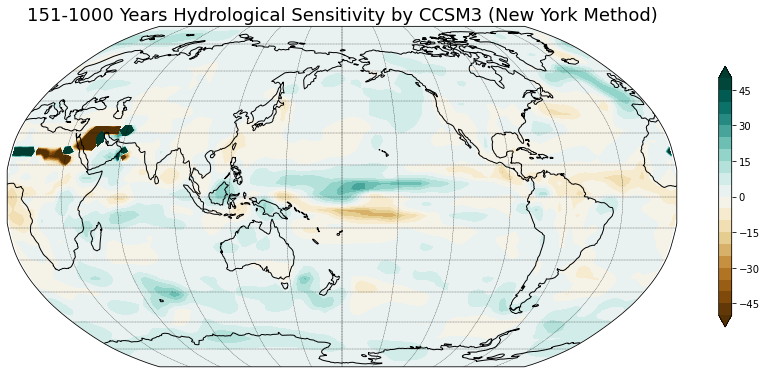

In [134]:
# Plot Contour Map
Map_Plotting("CCSM3", "1-20 Years")
Map_Plotting("CCSM3", "21-150 Years")
Map_Plotting("CCSM3", "151-1000 Years")

In [28]:

#did not complete this - not needed for final figure

# Calculate Intermodel Average of Hydrological Sensitivities
i = 0
Hydro_Sensi_Sum = 0
for Model in Model_List:
# Calculate Sum of Hydrological Sensitivities
    Hydro_Sensi_Sum += Hydro_Sensi_Dict[Model]
    i += 1
#
# Divide dy Number of Models
Hydro_Sensi_Mean = Hydro_Sensi_Sum / 11
#Hydro_Sensi_Mean

/Users/angelinependergrass/miniconda3/envs/lrmipk/lib/python3.12/site-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/110m_physical/ne_110m_coastline.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)


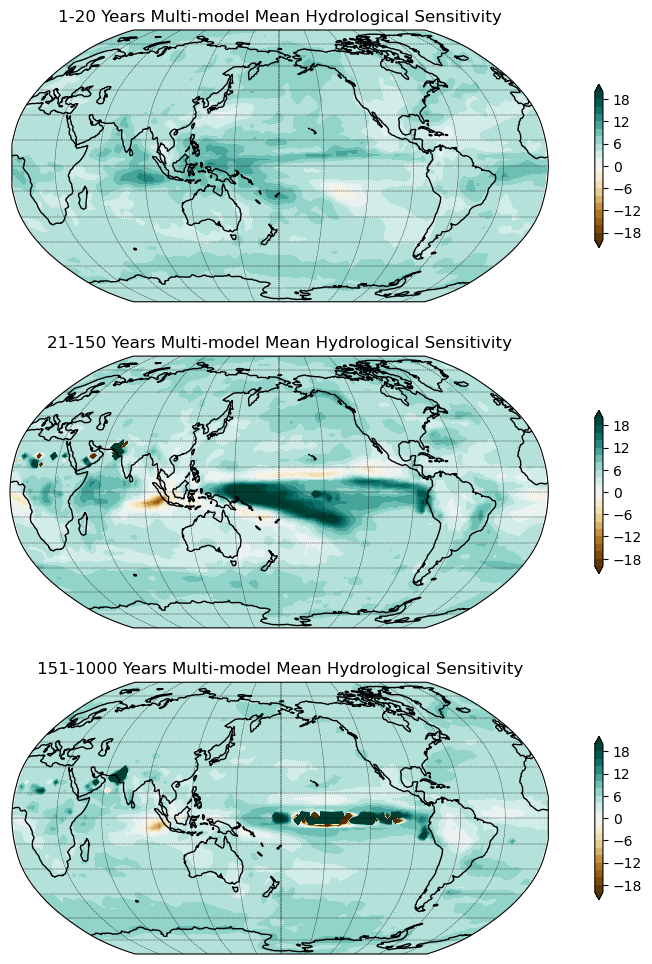

In [29]:
### not using this for final figure - delete

# Plot Contour Map of Intermodel Mean Hydrological Sensitivity
def Map_Plotting_Mean(Period):
# Create Figure
#    Fig = pyplot.figure(figsize=(15, 6))
#
# Define Axis
#    Axis = Fig.add_subplot(1, 1, 1, projection=ccrs.Robinson(central_longitude=180))
#
# Define Colour Levels
    Colour_Levels = numpy.empty(21)
    for i in range(len(Colour_Levels)):
        Colour_Levels[i] = 2 * i - 20
#
# Plot Colour Contour For 1-20 Years Slope
    if Period == "1-20 Years":
        Period_Code = 0
    if Period == "21-150 Years":
        Period_Code = 1
    if Period == "151-1000 Years":
        Period_Code = 2
    Hydro_Sensi_Data = Hydro_Sensi_Mean[:,:,Period_Code]
    Colour_Plot = Axis.contourf(Hydro_Sensi_Data.Lon, Hydro_Sensi_Data.Lat, Hydro_Sensi_Data, \
    cmap='BrBG', levels=Colour_Levels, extend="both", transform=ccrs.PlateCarree())
#
# Draw Coastlines
    Axis.coastlines()
#
# Set Axis Labels
    x_Axis = []
    for l in range(13):
        x_Axis.append(30*l-180)
    y_Axis = []
    for k in range(13):
        y_Axis.append(15*k-90)
#    Axis.set_xticks(x_Axis)
#    Axis.set_yticks(y_Axis)
#
# Add a Rectangular Line Grid to the Interior of the Plot
    Gridline = Axis.gridlines(crs=ccrs.PlateCarree(), linewidth=0.3, color='black', linestyle='--')
    Gridline.xlocator = mticker.FixedLocator(x_Axis)
    Gridline.ylocator = mticker.FixedLocator(y_Axis)
#
# Create Colour Bar
#    if Period_Code == 2:
    Colour_Bar = pyplot.colorbar(Colour_Plot, shrink=0.6)
#
# Add Title
    Title = Period + " Multi-model Mean Hydrological Sensitivity"
    pyplot.title(Title, fontsize=12)
#
# Output Figure
    if Period_Code == 0:
        Fig_Name = "Mean_Hydro_Sensi_Map_1_20"
    if Period_Code == 1:
        Fig_Name = "Mean_Hydro_Sensi_Map_21_150"
    if Period_Code == 2:
        Fig_Name = "Mean_Hydro_Sensi_Map_151_1000"
#    Fig.savefig(Fig_Name+'.png', bbox_inches='tight')
#
#
# Create Figs
Fig = pyplot.figure(figsize=(12,12))
Count = 0
for i in range(3):
#
# Plot Contour Map of Intermodel Mean Hydrological Sensitivity
    Count += 1
    Axis = Fig.add_subplot(3,1, Count, projection=ccrs.Robinson(central_longitude=180))
    if Count == 1:
        Map_Plotting_Mean("1-20 Years")
    if Count == 2:
        Map_Plotting_Mean("21-150 Years")
    if Count == 3:
        Map_Plotting_Mean("151-1000 Years")
#        Colour_Bar = pyplot.colorbar(Colour_Plot, shrink=0.6, orientation="horizontal")
#    Fig.savefig('Mean_Hydro_Sensi_Maps.png', bbox_inches='tight')